In [15]:
%pylab inline
import numpy as np
import astropy.table
from astropy.io import fits
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pickle
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
plt.rc('font', size=10, family='serif')

In [3]:
train_data = astropy.table.Table.read('/global/homes/p/parkerf/spec1_mean_data_2018may02_a.fits')
test_data = astropy.table.Table.read('/global/homes/p/parkerf/spec2_mean_data_2018may02_a.fits')

In [4]:
lines = pickle.load(open('/global/homes/p/parkerf/Sky/SkyModelling/util/line_file_updated.pkl','rb'))
for cam, info in lines.items():
    if (cam == 'b1') | (cam=='r1'):
        print(info)

{'cont_b_425': ['cont', 425], 'cont_b_460': ['cont', 460], 'cont_b_602': ['cont', 602], 'cont_b_510': ['cont', 510], 'cont_b_410': ['cont', 410], 'cont_b_540': ['cont', 540], 'Hg': ['line', 435.95], 'cont_b_583': ['cont', 583], 'OI': ['line', 557.89], 'cont_b_480': ['cont', 480], 'cont_b_615': ['cont', 615], 'cont_b_565': ['cont', 565], 'cont_b_380': ['cont', 380]}
{'cont_b_977': ['cont', 977], 'cont_b_740': ['cont', 740], 'cont_b_642': ['cont', 642], 'B': ['line', 888.83], 'cont_b_720': ['cont', 720], 'cont_b_710': ['cont', 710], 'cont_b_833': ['cont', 833], 'OH': ['line', 948.1], 'cont_b_873': ['cont', 873], 'red_D': ['line', 740], 'cont_b_920': ['cont', 920], 'cont_b_1025': ['cont', 1025], 'cont_b_825': ['cont', 825], 'cont_b_675': ['cont', 675]}


## Look at Data

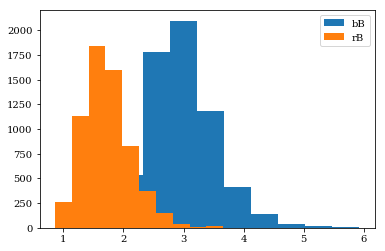

In [5]:
ret = plt.hist(train_data[train_data['CAMERAS']=='b1']['mean_cont_b_460'], label = 'bB')
ret = plt.hist(train_data[train_data['CAMERAS']=='r1']['mean_cont_b_710'], label = 'rB')
plt.legend()

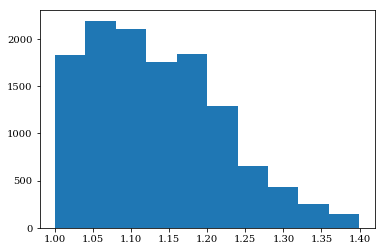

In [337]:
ret = plt.hist(train_data['AIRMASS'])

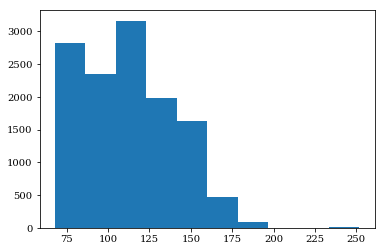

In [338]:
ret = plt.hist(train_data['SOLARFLUX'])

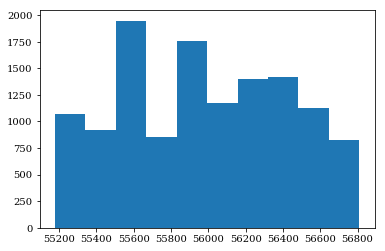

In [339]:
ret = plt.hist(train_data['MJD'])

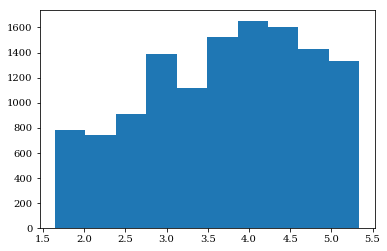

In [340]:
ret = plt.hist(train_data['ZODI_IO'])

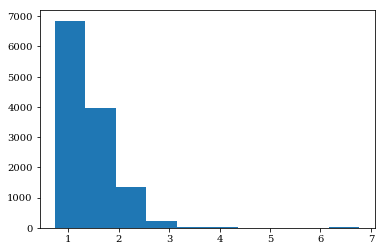

In [342]:
ret = plt.hist(train_data['ISL'])

1.43333333333 12.5833333333


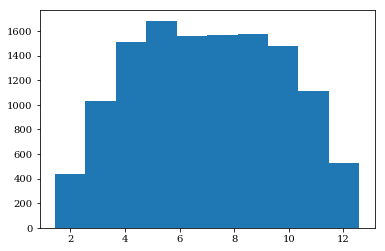

In [343]:
ret = plt.hist(train_data['HOUR'])
print(min(train_data['HOUR']),max(train_data['HOUR']))

1 12


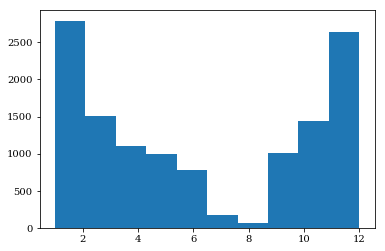

In [344]:
ret = plt.hist(train_data['MONTH'])
print(min(train_data['MONTH']),max(train_data['MONTH']))

In [61]:
train_data.remove_rows(np.where(train_data['EXPTIME']>905))
train_data.remove_rows(np.where(train_data['EXPTIME']<895))

2.98912 0.545002
1.72777 0.391307


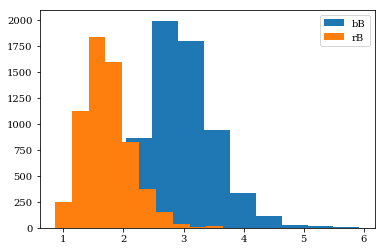

In [74]:
ret = plt.hist(train_data[train_data['CAMERAS']=='b1']['mean_cont_b_460'], label = 'bB')
print(np.mean(train_data[train_data['CAMERAS']=='b1']['mean_cont_b_460']),np.std(train_data[train_data['CAMERAS']=='b1']['mean_cont_b_460']))
ret = plt.hist(train_data[train_data['CAMERAS']=='r1']['mean_cont_b_710'], label = 'rB')
print(np.mean(train_data[train_data['CAMERAS']=='r1']['mean_cont_b_710']),np.std(train_data[train_data['CAMERAS']=='r1']['mean_cont_b_710']))
plt.legend()

## Build Linear Model

In [62]:
blue_train = train_data[train_data['CAMERAS'] == 'b1']
blue_test = test_data[test_data['CAMERAS'] == 'b2']

2.66377 0.492623


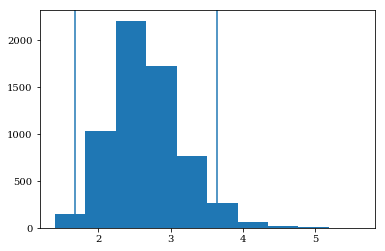

In [78]:
print(np.mean(blue_train['mean_cont_b_480']), np.std(blue_train['mean_cont_b_480']))
ret = plt.hist(blue_train['mean_cont_b_480'])
plt.axvline(np.mean(blue_train['mean_cont_b_480'])+2*np.std(blue_train['mean_cont_b_480']))
plt.axvline(np.mean(blue_train['mean_cont_b_480'])-2*np.std(blue_train['mean_cont_b_480']))

2.62192 0.418017


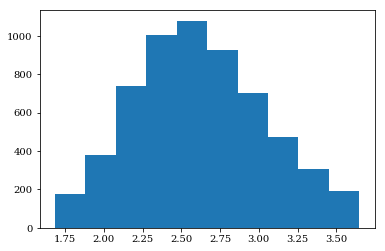

In [81]:
sigu = np.mean(blue_train['mean_cont_b_480'])+2*np.std(blue_train['mean_cont_b_480'])
sigl = np.mean(blue_train['mean_cont_b_480'])-2*np.std(blue_train['mean_cont_b_480'])
new_blue_train = blue_train[(blue_train['mean_cont_b_480']<sigu)&(blue_train['mean_cont_b_480']>sigl)]
ret = plt.hist(new_blue_train['mean_cont_b_480'])
print(np.mean(new_blue_train['mean_cont_b_480']),np.std(new_blue_train['mean_cont_b_480']))

In [82]:
blue_train = new_blue_train

In [63]:
red_train = train_data[train_data['CAMERAS'] == 'r1']
red_test = test_data[test_data['CAMERAS'] == 'r2']

In [64]:
# For Zodi
wave_range = np.linspace(360,1040,(1040-360))
sun_s = np.loadtxt('/global/homes/p/parkerf/solarspec.txt')
sun_s = interp1d(sun_s[:,1], sun_s[:,2], bounds_error = False, fill_value=0)
solar_spectrum = sun_s(wave_range*10)

nm_500 = [np.abs(500.-w) for w in wave_range]
nm_id = np.argmin(nm_500)
f_abs = solar_spectrum/solar_spectrum[nm_id]

In [65]:
#For ISL
mattila = np.loadtxt('/global/homes/p/parkerf/mattila.csv')
isl_s = interp1d(mattila[:,0]/10., mattila[:,1], bounds_error = False, fill_value="extrapolate")
isl_spectrum = isl_s(wave_range)
        
nm_440 = [np.abs(440. - w) for w in wave_range]
idx = np.argmin(nm_440)
relative_isl = isl_spectrum/isl_spectrum[idx]

In [66]:
def create_feature_list(data_table, line):
    months = np.zeros((len(data_table), 12))
    blue_months = np.array(data_table['MONTH']-1)
    
    months_ = []
    for i, month in enumerate(months):
        month[blue_months[i]] = 1
        months_.append(month)
    df1 = pd.DataFrame(months_, columns = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
    
    hours = np.zeros((len(data_table), 12))
    blue_hours = np.array(data_table['HOUR'])
    hours_ = []
    for i, hour in enumerate(hours):
        b_hour = np.rint(blue_hours[i])
        if b_hour == 13:
            b_hour = 1
        hour[int(b_hour)-1] = 1
        hours_.append(hour)
    df2 = pd.DataFrame(hours_, columns = ['H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12'])
    
    idx = np.where((wave_range>(line-5))&(wave_range<(line+5)))
    zodi_f = np.mean(f_abs[idx])
    zz = zodi_f*data_table['ZODI_IO']
    
    isl_f = np.mean(relative_isl[idx])
    isl = isl_f*data_table['ISL']
    
    airtemp = 5 - data_table['AIRTEMP']
    
    df3 = pd.DataFrame([data_table['AIRMASS'],data_table['SOLARFLUX'],data_table['WINDS'],zz, isl, airtemp]).T
    df3.columns = ['AIRMASS', 'SOLARFLUX','WINDS','ZODI','ISL','AIRTEMP',]
    
    df = pd.concat([df3, df1, df2],axis=1)
    #df = df.drop(columns = ['JAN','H1'])
    X = sm.add_constant(df)
    
    return X

In [88]:
def run_model(data_table, line, data_name):
    X = create_feature_list(data_table, line)
    print(X.shape)
    Y = data_table[data_name]
    
    results = sm.OLS(Y,X).fit()
    params = results.params
    model = np.dot(X, params)
    print(results.summary())
    res = Y - model
    
    rms_y = np.std(Y)
    rms_res = np.std(res)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.plot(model, res, 'x')
    r = ax2.hist(res,bins = 25, label = 'data rms/res rms: %.2f' % (rms_y/float(rms_res)))
    fig.suptitle(data_name)
    ax1.set_xlabel("Model")
    ax1.set_ylabel("Residuals (data - model)")
    ax2.set_xlabel("Distribution of residuals")
    ax2.legend(loc = 'upper right')
    plt.show()
    print(params)
    return params

In [85]:
def test_model(data_table, line, data_name, params):
    X = create_feature_list(data_table, line)
    model = np.dot(X, params)
    
    Y = data_table[data_name]
    res = Y - model
    rms_y = np.std(Y)
    rms_res = np.std(res)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.plot(model, res, 'x')
    r = ax2.hist(res, bins = 25, label = 'data rms/res rms: %.2f' % (rms_y/float(rms_res)))
    fig.suptitle(data_name)
    ax1.set_xlabel("Model")
    ax1.set_ylabel("Residuals (data - model)")
    ax2.set_xlabel("Distribution of residuals")
    ax2.legend(loc = 'upper right')
    plt.show()

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     198.9
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:37   Log-Likelihood:                -3128.0
No. Observations:                5979   AIC:                             6314.
Df Residuals:                    5950   BIC:                             6508.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4000      0.073     -5.4

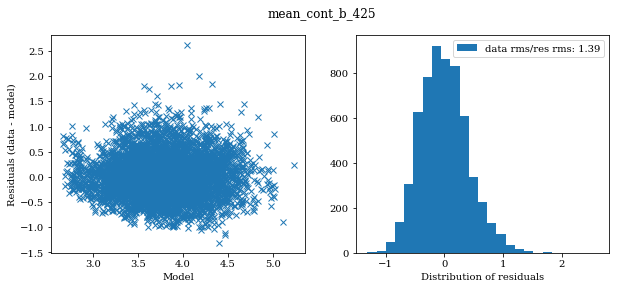

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     285.0
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:38   Log-Likelihood:                -1345.9
No. Observations:                5979   AIC:                             2750.
Df Residuals:                    5950   BIC:                             2944.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1930      0.054     -3.5

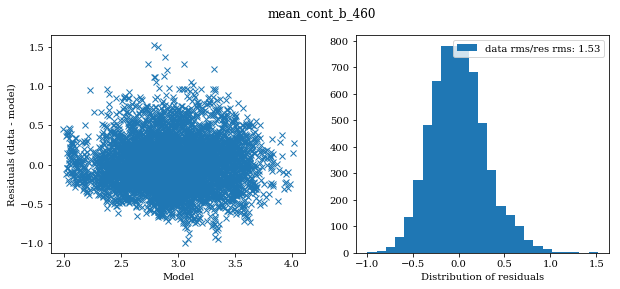

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     220.9
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:39   Log-Likelihood:                -3756.3
No. Observations:                5979   AIC:                             7571.
Df Residuals:                    5950   BIC:                             7765.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1857      0.081     -2.2

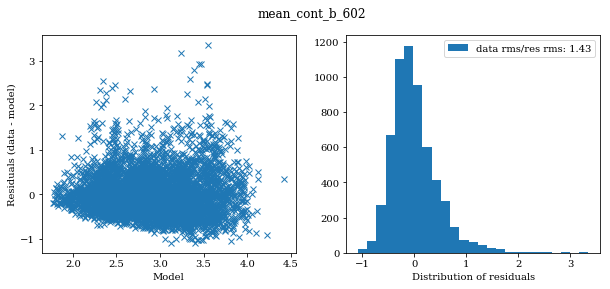

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     398.1
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:39   Log-Likelihood:                -201.68
No. Observations:                5979   AIC:                             461.4
Df Residuals:                    5950   BIC:                             655.5
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4402      0.045     -9.8

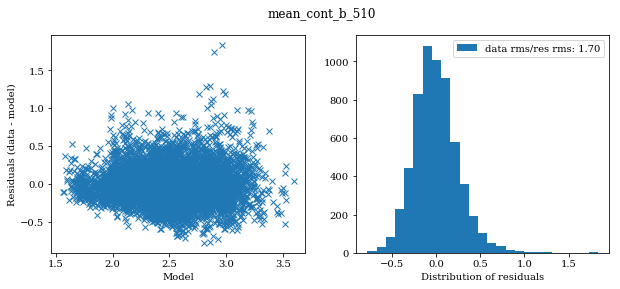

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     169.0
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:40   Log-Likelihood:                -3378.9
No. Observations:                5979   AIC:                             6816.
Df Residuals:                    5950   BIC:                             7010.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0443      0.076      0.5

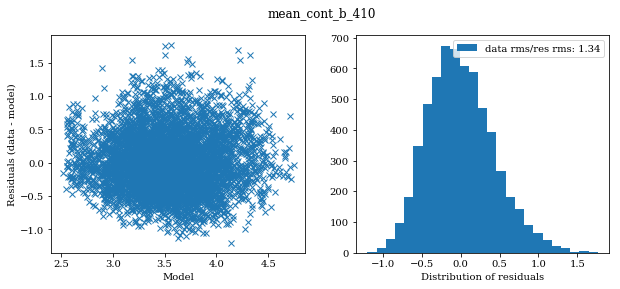

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     413.6
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:41   Log-Likelihood:                 667.42
No. Observations:                5979   AIC:                            -1277.
Df Residuals:                    5950   BIC:                            -1083.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1701      0.039     -4.4

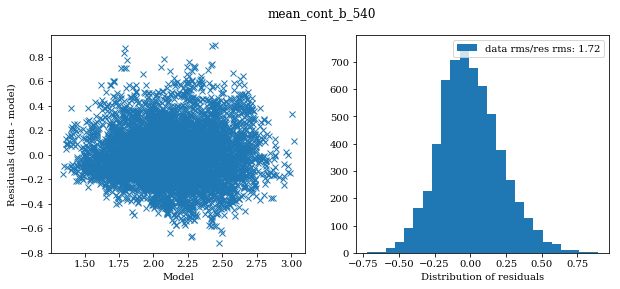

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     221.2
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:41   Log-Likelihood:                -3863.4
No. Observations:                5979   AIC:                             7785.
Df Residuals:                    5950   BIC:                             7979.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2471      0.082     -3.0

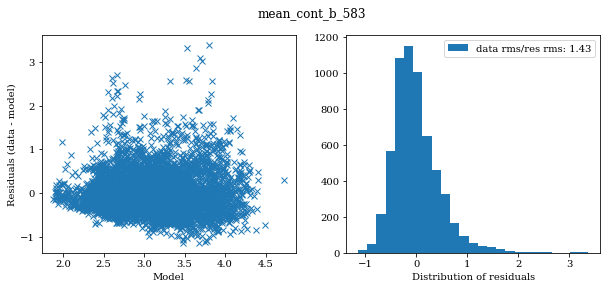

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     387.5
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:42   Log-Likelihood:                -165.90
No. Observations:                5979   AIC:                             389.8
Df Residuals:                    5950   BIC:                             584.0
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1197      0.044     -2.7

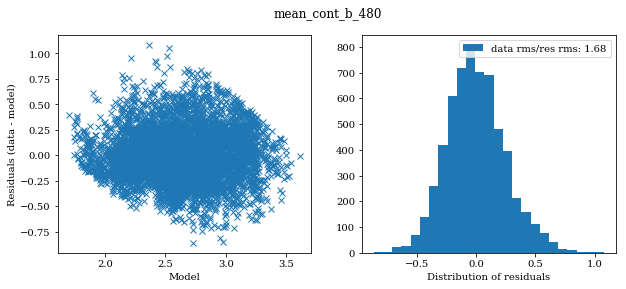

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     250.6
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:43   Log-Likelihood:                -1612.0
No. Observations:                5979   AIC:                             3282.
Df Residuals:                    5950   BIC:                             3476.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1747      0.056     -3.0

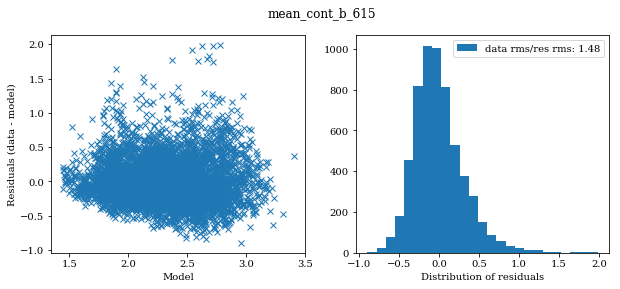

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     393.7
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:43   Log-Likelihood:                -1429.1
No. Observations:                5979   AIC:                             2916.
Df Residuals:                    5950   BIC:                             3110.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1764      0.055     -3.2

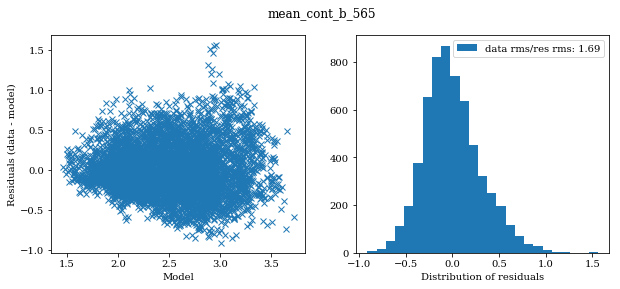

(5979, 31)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     97.67
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        13:13:44   Log-Likelihood:                -5443.5
No. Observations:                5979   AIC:                         1.095e+04
Df Residuals:                    5950   BIC:                         1.114e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2030      0.107      1.8

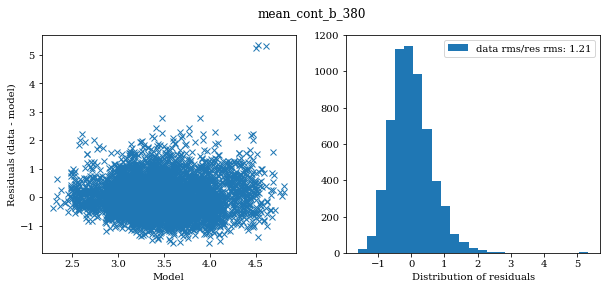

In [86]:
blue_params = {}
for cam, info in lines.items():
    if (cam == 'b1'):
        for name, x in info.items():
            if x[0] == 'cont':
                blue_params[name] = run_model(blue_train, x[1], 'mean_'+name)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     156.9
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:39   Log-Likelihood:                 2560.0
No. Observations:                6246   AIC:                            -5062.
Df Residuals:                    6217   BIC:                            -4867.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0582      0.027      2.132      0.0

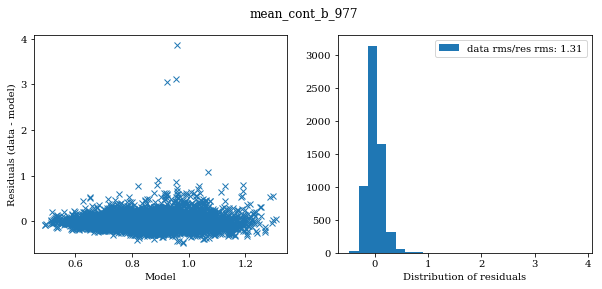

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     349.5
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:40   Log-Likelihood:                -1944.9
No. Observations:                6246   AIC:                             3948.
Df Residuals:                    6217   BIC:                             4143.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0879      0.056     -1.564      0.1

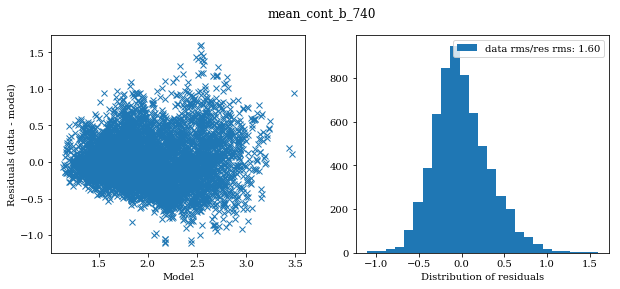

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     378.2
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:41   Log-Likelihood:                -2131.0
No. Observations:                6246   AIC:                             4320.
Df Residuals:                    6217   BIC:                             4515.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2680      0.058     -4.629      0.0

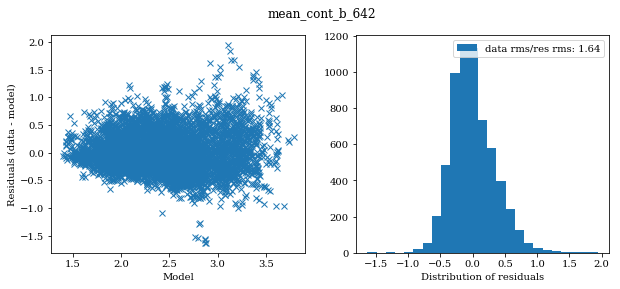

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     397.0
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:41   Log-Likelihood:                 474.10
No. Observations:                6246   AIC:                            -890.2
Df Residuals:                    6217   BIC:                            -694.8
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0867      0.038     -2.272      0.0

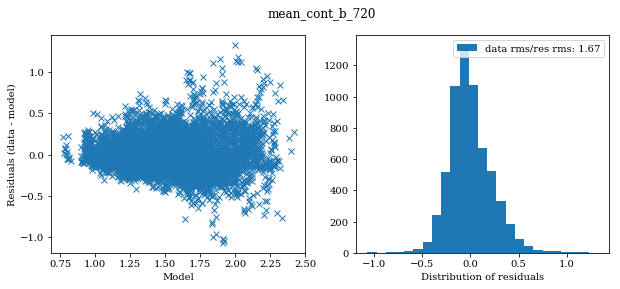

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     413.5
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:42   Log-Likelihood:                 269.46
No. Observations:                6246   AIC:                            -480.9
Df Residuals:                    6217   BIC:                            -285.5
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1926      0.039     -4.887      0.0

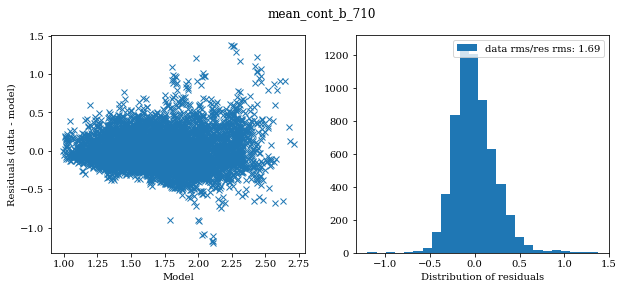

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     362.2
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:43   Log-Likelihood:                 1851.2
No. Observations:                6246   AIC:                            -3644.
Df Residuals:                    6217   BIC:                            -3449.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1290      0.031     -4.217      0.0

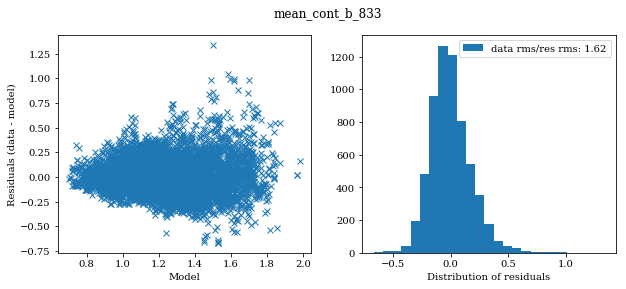

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     233.0
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:43   Log-Likelihood:                 262.09
No. Observations:                6246   AIC:                            -466.2
Df Residuals:                    6217   BIC:                            -270.7
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.039     -0.108      0.9

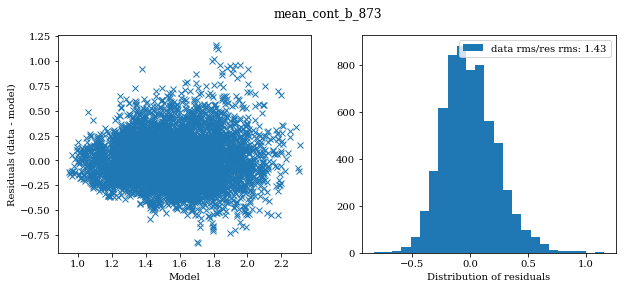

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     322.8
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:44   Log-Likelihood:                 3755.9
No. Observations:                6246   AIC:                            -7454.
Df Residuals:                    6217   BIC:                            -7258.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.023     -0.195      0.8

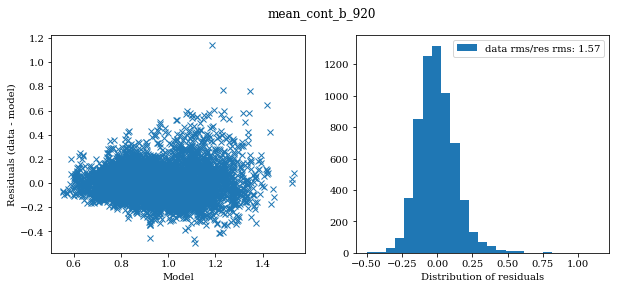

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     69.53
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:45   Log-Likelihood:                -369.84
No. Observations:                6246   AIC:                             797.7
Df Residuals:                    6217   BIC:                             993.1
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2581      0.044      5.912      0.0

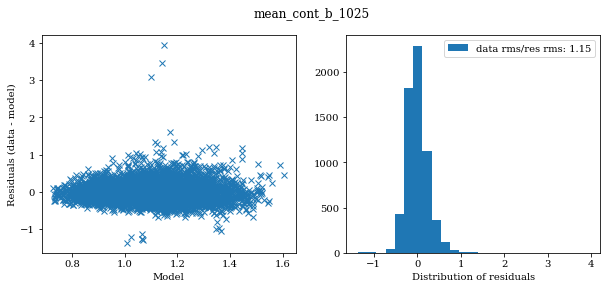

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     240.6
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:45   Log-Likelihood:                -1208.2
No. Observations:                6246   AIC:                             2474.
Df Residuals:                    6217   BIC:                             2670.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0371      0.050     -0.743      0.4

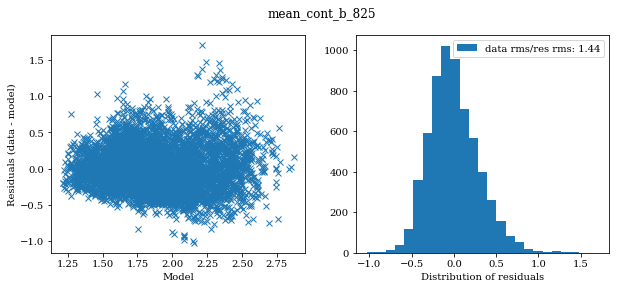

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     399.1
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        10:59:46   Log-Likelihood:                -380.49
No. Observations:                6246   AIC:                             819.0
Df Residuals:                    6217   BIC:                             1014.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2304      0.044     -5.268      0.0

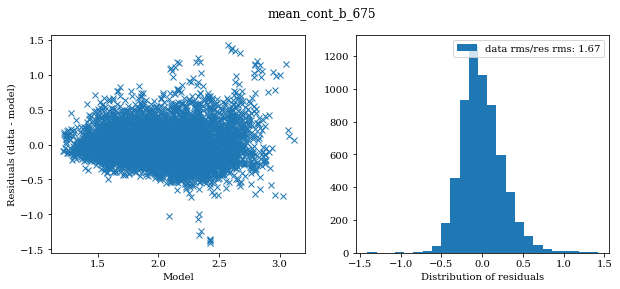

In [51]:
red_params = {}
for cam, info in lines.items():
    if (cam == 'r1'):
        for name, x in info.items():
            if x[0] == 'cont':
                red_params[name] = run_model(red_train, x[1], 'mean_'+name)

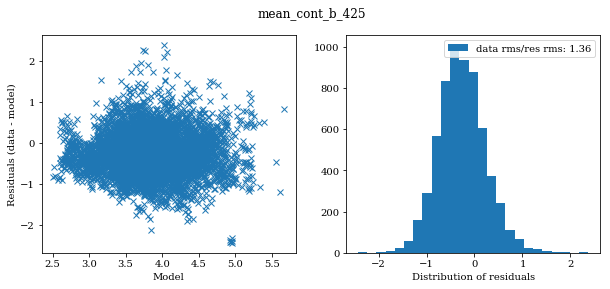

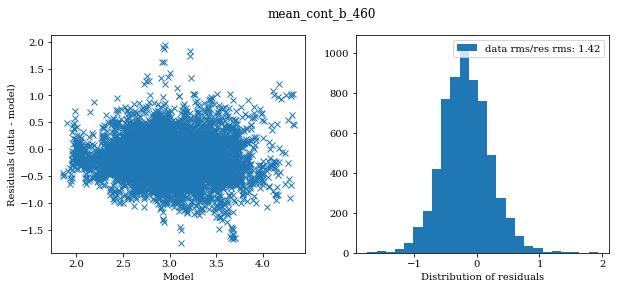

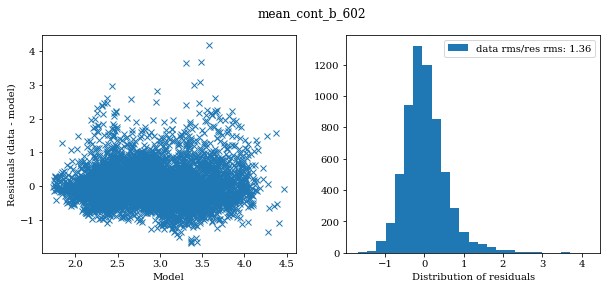

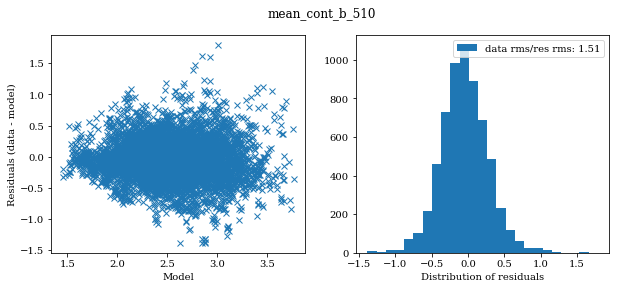

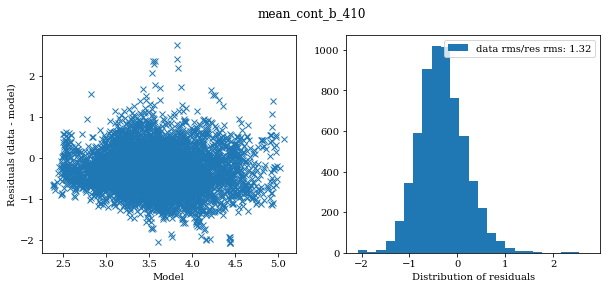

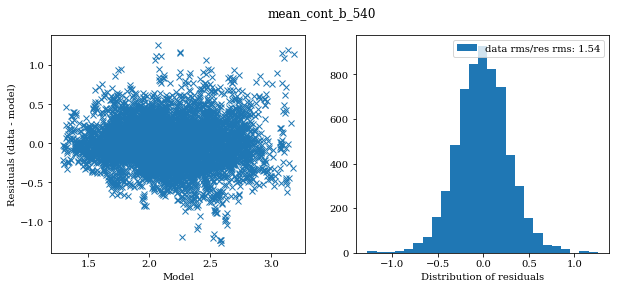

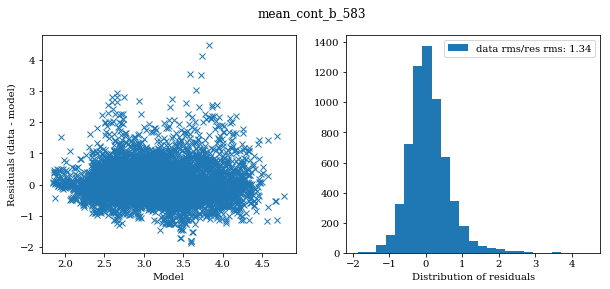

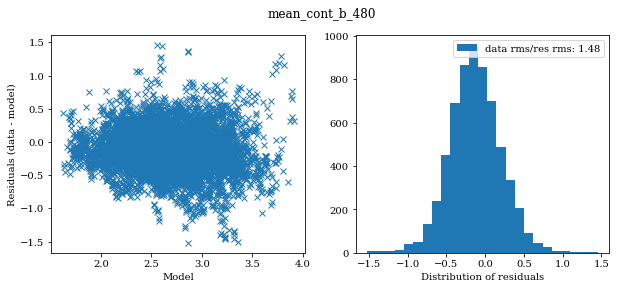

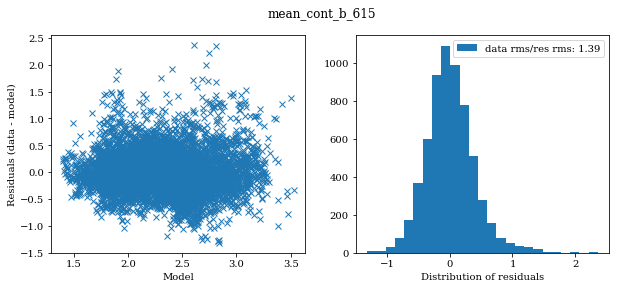

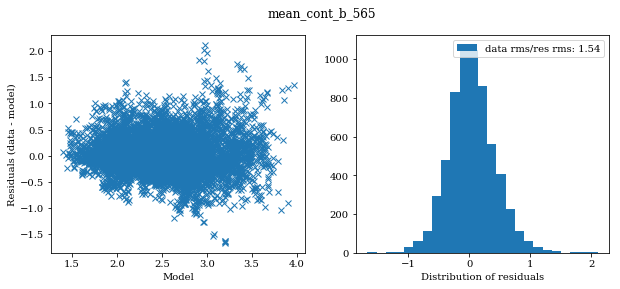

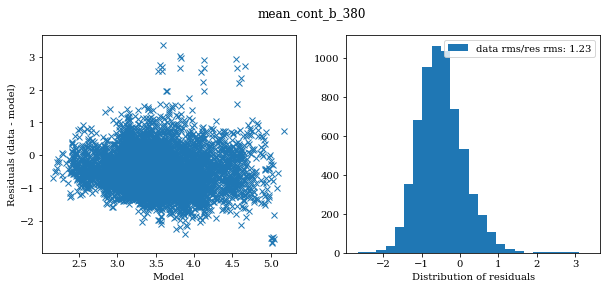

In [52]:
for cam, info in lines.items():
    if (cam == 'b1'):
        for name, x in info.items():
            if x[0] == 'cont':
                test_model(blue_test, x[1], 'mean_'+name, blue_params[name])

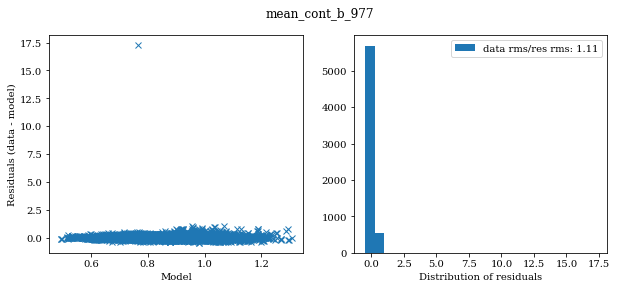

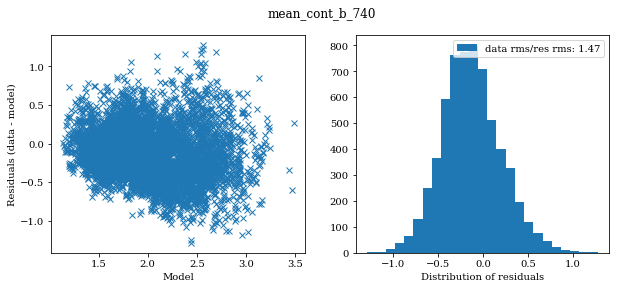

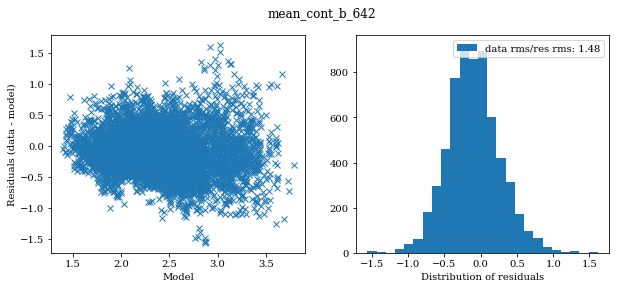

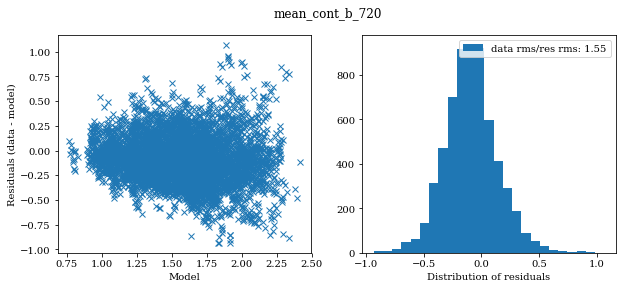

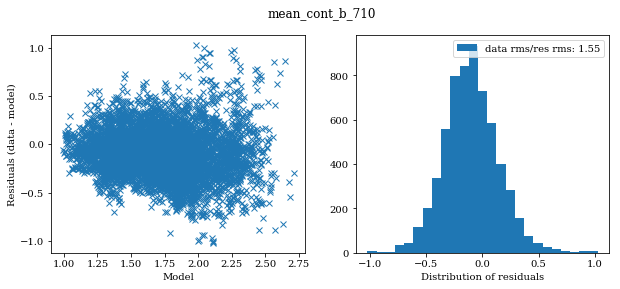

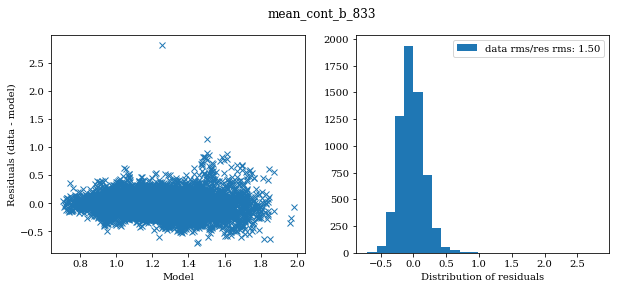

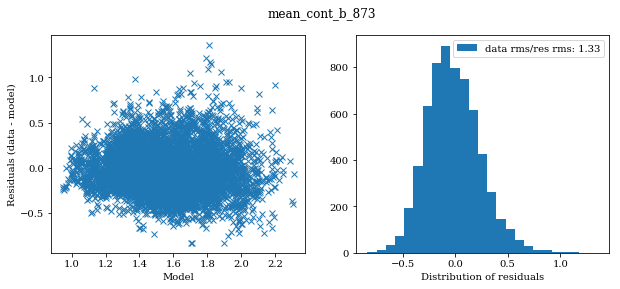

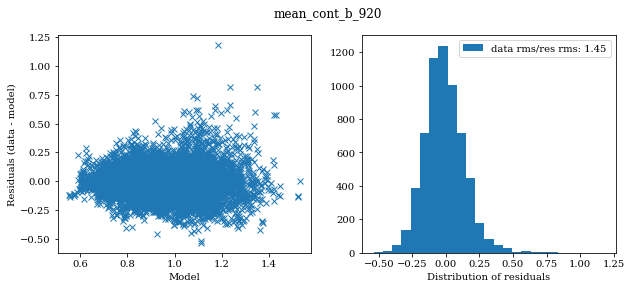

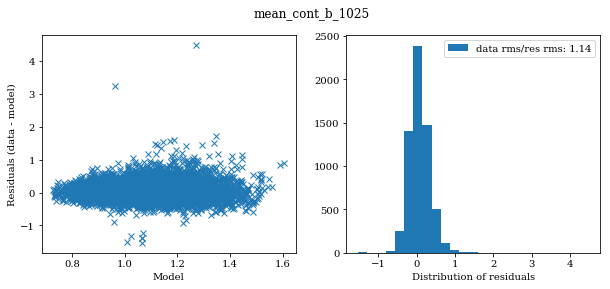

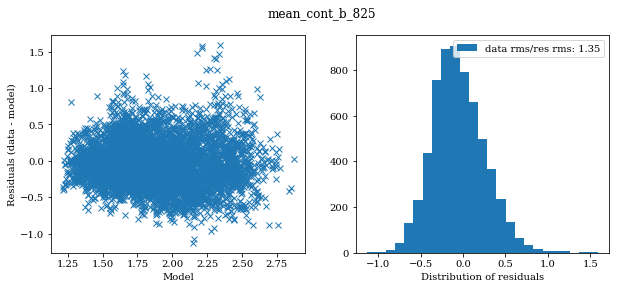

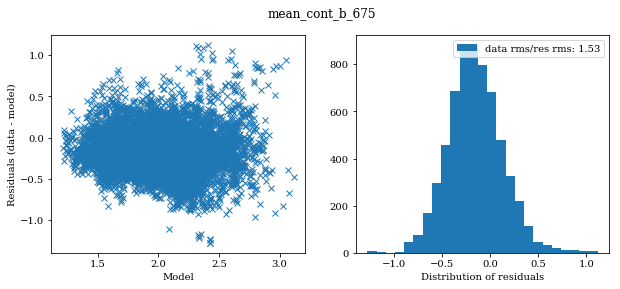

In [53]:
for cam, info in lines.items():
    if (cam == 'r1'):
        for name, x in info.items():
            if x[0] == 'cont':
                test_model(red_test, x[1], 'mean_'+name, red_params[name])

## Look at parameters

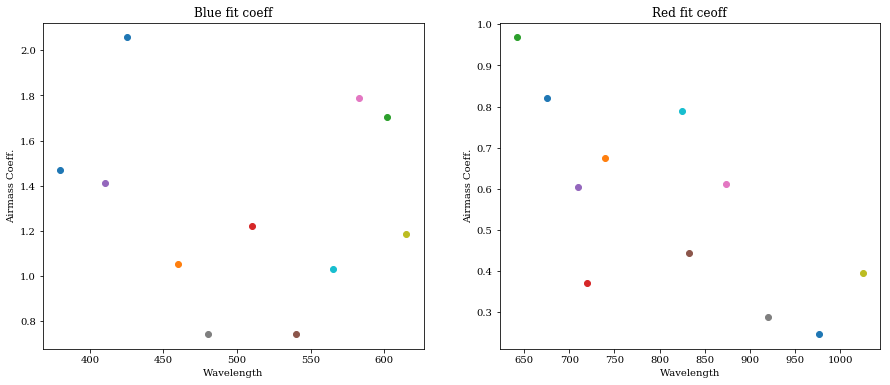

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
for name, params in blue_params.items():
    blue_lines = lines['b1']
    wave = blue_lines[name][1]
    ax1.plot(wave, params.AIRMASS,'o')
for name, params in red_params.items():
    red_lines = lines['r1']
    wave = red_lines[name][1]
    ax2.plot(wave, params.AIRMASS,'o')
ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Airmass Coeff.")
ax1.set_title("Blue fit coeff")
ax2.set_xlabel("Wavelength")
ax2.set_ylabel("Airmass Coeff.")
ax2.set_title("Red fit ceoff")

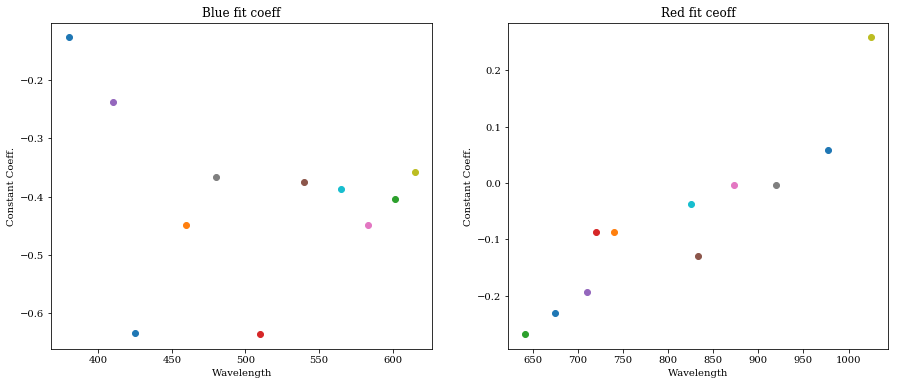

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
for name, params in blue_params.items():
    blue_lines = lines['b1']
    wave = blue_lines[name][1]
    ax1.plot(wave, params.const,'o')
for name, params in red_params.items():
    red_lines = lines['r1']
    wave = red_lines[name][1]
    ax2.plot(wave, params.const,'o')
ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Constant Coeff.")
ax1.set_title("Blue fit coeff")
ax2.set_xlabel("Wavelength")
ax2.set_ylabel("Constant Coeff.")
ax2.set_title("Red fit ceoff")

In [33]:
from matplotlib import colors as mcolors

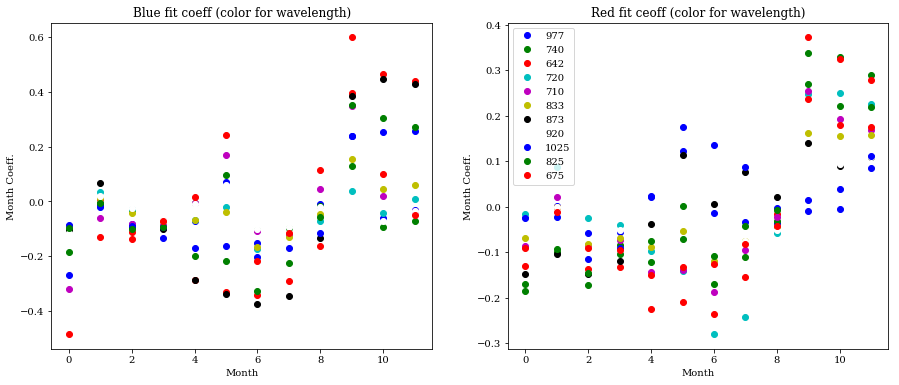

In [35]:
months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
colors = [key for key in mcolors.BASE_COLORS.keys()]
cb = 0
cr = 0

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
for name, params in blue_params.items():
    blue_lines = lines['b1']
    wave = blue_lines[name][1]
    for i,month in enumerate(months):
        try:
            ax1.plot(i, params[month],'o',color = colors[cb], label = wave)
        except:
            ax1.plot(i, params[month],'o',color = colors[cb-8], label = wave)
    cb = cb+1
for name, params in red_params.items():
    red_lines = lines['r1']
    wave = red_lines[name][1]
    for i,month in enumerate(months):
        if i == 0:
            try:
                ax2.plot(i, params[month],'o',color = colors[cr], label = wave)
            except:
                ax2.plot(i, params[month],'o',color = colors[cr-8], label = wave)
        else:
            try:
                ax2.plot(i, params[month],'o',color = colors[cr])
            except:
                ax2.plot(i, params[month],'o',color = colors[cr-8])
    cr = cr + 1
    
ax1.set_xlabel("Month")
ax1.set_ylabel("Month Coeff.")
ax1.set_title("Blue fit coeff (color for wavelength)")
ax2.set_xlabel("Month")
ax2.set_ylabel("Month Coeff.")
ax2.set_title("Red fit ceoff (color for wavelength)")
ax2.legend(loc='upper left')

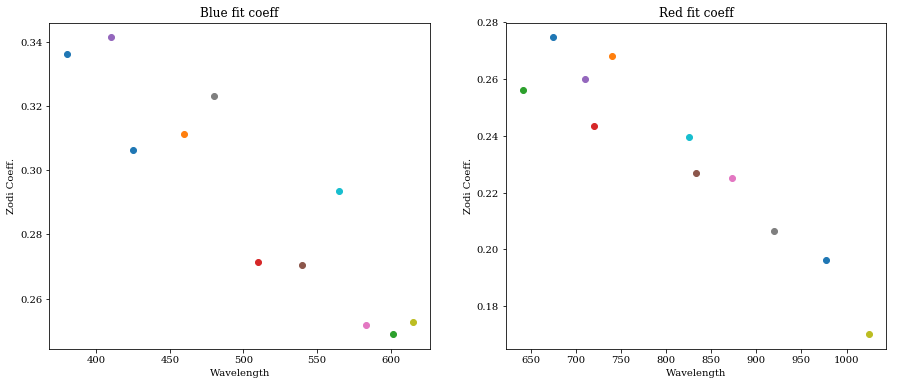

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
for name, params in blue_params.items():
    blue_lines = lines['b1']
    wave = blue_lines[name][1]
    ax1.plot(wave, params.ZODI,'o')
for name, params in red_params.items():
    red_lines = lines['r1']
    wave = red_lines[name][1]
    ax2.plot(wave, params.ZODI,'o')
ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Zodi Coeff.")
ax1.set_title("Blue fit coeff")
ax2.set_xlabel("Wavelength")
ax2.set_ylabel("Zodi Coeff.")
ax2.set_title("Red fit coeff")

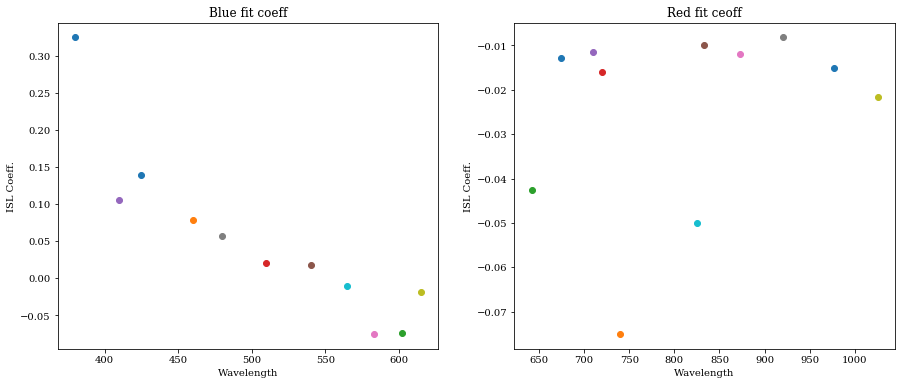

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
for name, params in blue_params.items():
    blue_lines = lines['b1']
    wave = blue_lines[name][1]
    ax1.plot(wave, params.ISL,'o')
for name, params in red_params.items():
    red_lines = lines['r1']
    wave = red_lines[name][1]
    ax2.plot(wave, params.ISL,'o')
ax1.set_xlabel("Wavelength")
ax1.set_ylabel("ISL Coeff.")
ax1.set_title("Blue fit coeff")
ax2.set_xlabel("Wavelength")
ax2.set_ylabel("ISL Coeff.")
ax2.set_title("Red fit ceoff")

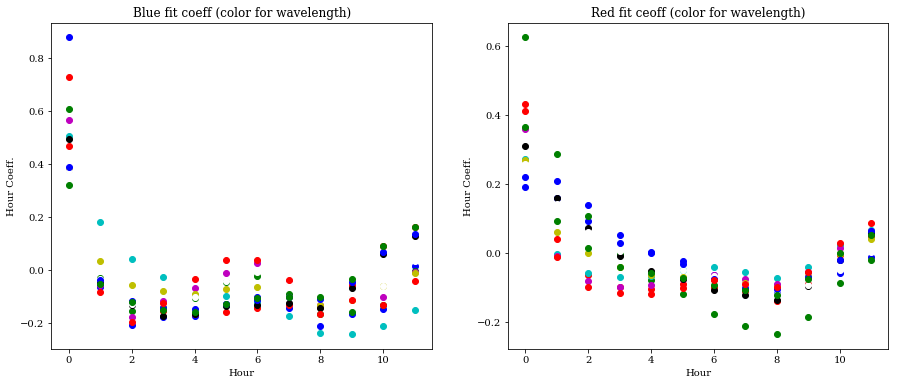

In [38]:
hours = ['H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12']
colors = [key for key in mcolors.BASE_COLORS.keys()]
cb = 0
cr = 0

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
for name, params in blue_params.items():
    blue_lines = lines['b1']
    wave = blue_lines[name][1]
    for i,hour in enumerate(hours):
        try:
            ax1.plot(i, params[hour],'o',color = colors[cb], label = wave)
        except:
            ax1.plot(i, params[hour],'o',color = colors[cb-8], label = wave)
    cb = cb+1
for name, params in red_params.items():
    red_lines = lines['r1']
    wave = red_lines[name][1]
    for i, hour in enumerate(hours):
        try:
            ax2.plot(i, params[hour],'o',color = colors[cr], label = wave)
        except:
            ax2.plot(i, params[hour],'o',color = colors[cr-8], label = wave)
    cr = cr + 1
    
ax1.set_xlabel("Hour")
ax1.set_ylabel("Hour Coeff.")
ax1.set_title("Blue fit coeff (color for wavelength)")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Hour Coeff.")
ax2.set_title("Red fit ceoff (color for wavelength)")